### 라이브러리 불러오기

In [1]:
import pandas as pd
import pickle
import numpy as np
import re
from sklearn import linear_model

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import joblib


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm_notebook

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

import os
import warnings
warnings.filterwarnings('ignore') 

def get_score(y_test, y_pred):
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)
    
    return(mae, mse, rmse, r2)

In [2]:
# 데이터 불러오기
#data = pd.read_csv('2008~2023_data.csv', engine='python')
data = pd.read_parquet('2008~2023_data.parquet')

In [3]:
data.head()

,Date,Line_num,Station,Station_num,Time,holiday,weekday,geton,getoff,get_all,...,Snow_amt_mean,Rainfall_amt_sum,Snow_amt_sum,Temp_max,Temp_min,Temp_diff,hour,year,month,day
0,2008-01-01,1,서울역(150),150,00:00,1,2,264.0,558.0,822.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
1,2008-01-01,1,시청(151),151,00:00,1,2,974.0,185.0,1159.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
2,2008-01-01,1,종각(152),152,00:00,1,2,1559.0,210.0,1769.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
3,2008-01-01,1,종로3가(153),153,00:00,1,2,1499.0,384.0,1883.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
4,2008-01-01,1,종로5가(154),154,00:00,1,2,140.0,42.0,182.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30239475 entries, 0 to 30239474
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date               object 
 1   Line_num           int64  
 2   Station            object 
 3   Station_num        int64  
 4   Time               object 
 5   holiday            int64  
 6   weekday            int64  
 7   geton              float64
 8   getoff             float64
 9   get_all            float64
 10  Temp               float64
 11  Rainfall_amt       float64
 12  Wind_speed         float64
 13  Humidity           float64
 14  Snow_amt           float64
 15  Temp_mean          float64
 16  Rainfall_amt_mean  float64
 17  Wind_speed_mean    float64
 18  Humidity_mean      float64
 19  Snow_amt_mean      float64
 20  Rainfall_amt_sum   float64
 21  Snow_amt_sum       float64
 22  Temp_max           float64
 23  Temp_min           float64
 24  Temp_diff          float64
 25  hour            

### 데이터 사이즈가 너무 크기 때문에 샘플데이터를 통하여 모델 학습 진행

In [5]:
data = data[(data['year'] >= 2018) & (data['year'] <= 2023)]

### 파생변수 생성
- 비가 온날과 안온날 차이가 있었기 때문에 rainy 파생변수 생성

In [6]:
data['rainy'] = data['Rainfall_amt']>0.0
data['rainy'] = data['rainy'].astype(np.int32)

### 종속변수가 최대한 정규분포를 따라야 하고 이상치를 최소화 하기위해 로그 스케일링 진행

In [7]:
data['log_get_all'] = np.log1p(data['get_all'])

## 푸리에특징을 통한 시간연속성 표현(HOUR)
- 간단한 푸리에 변환을 활용하여, hour의 시간연속성을 데이터에 표현하였습니다.

In [8]:
def cyclical_encoding(x, max_val):
    sin_val = np.sin(2 * np.pi * x / max_val)
    cos_val = np.cos(2 * np.pi * x / max_val)
    return sin_val, cos_val

# hour 변수를 Cyclical Encoding으로 변환하여 대체하기
max_hour = 24
data['hour_sin'], data['hour_cos']= cyclical_encoding(data['hour'], max_hour)
data.drop('hour', axis=1, inplace=True)

# 결과 확인
data.head()

,Date,Line_num,Station,Station_num,Time,holiday,weekday,geton,getoff,get_all,...,Temp_max,Temp_min,Temp_diff,year,month,day,rainy,log_get_all,hour_sin,hour_cos
19688111,2018-01-01,1,서울역,150,00:00,1,1,96.0,147.0,243.0,...,3.7,-5.0,8.7,2018,1,1,0,5.497168,0.0,1.0
19688112,2018-01-01,1,시청,151,00:00,1,1,9.0,39.0,48.0,...,3.7,-5.0,8.7,2018,1,1,0,3.891820,0.0,1.0
19688113,2018-01-01,1,종각,152,00:00,1,1,28.0,33.0,61.0,...,3.7,-5.0,8.7,2018,1,1,0,4.127134,0.0,1.0
19688114,2018-01-01,1,종로3가,153,00:00,1,1,16.0,35.0,51.0,...,3.7,-5.0,8.7,2018,1,1,0,3.951244,0.0,1.0
19688115,2018-01-01,1,종로5가,154,00:00,1,1,8.0,28.0,36.0,...,3.7,-5.0,8.7,2018,1,1,0,3.610918,0.0,1.0


# 원핫인코딩 진행

In [ ]:
# One-hot encoding
selected_columns = ['log_get_all', 'holiday', 'rainy', 'hour_sin', 'hour_cos']
categorical_columns = ['Station_num', 'Line_num', 'weekday', 'month']

# Apply one-hot encoding to categorical columns
encoded_columns = []
for column in categorical_columns:
    encoded_df = pd.get_dummies(data[column], prefix=column, prefix_sep='_')
    encoded_columns.append(encoded_df)

# Encode the 'year' column separately
year_data = pd.get_dummies(data['year'], prefix='year', prefix_sep='_')
encoded_columns.append(year_data)

# Concatenate the selected columns and encoded columns
data_encoded = pd.concat([data[selected_columns]] + encoded_columns, axis=1)

### 훈련 데이터셋과 테스트 데이터셋 나누기
- 2018년부터 2021년까지의 데이터를 훈련 데이터로 사용하고, 2022년부터 2023년까지의 데이터를 테스트 데이터로 사용함. 이를 통해 모델은 과거 데이터를 기반으로 학습하여 미래의 데이터에 대해 예측 수행 할 수 있음.

In [ ]:

# Specify the start and end years for training and testing
train_start_year = 2018
train_end_year = 2021
test_start_year = 2022
test_end_year = 2023

# Filter the data based on the years
train_data = data_encoded[(data['year'] >= train_start_year) & (data['year'] <= train_end_year)]
test_data = data_encoded[(data['year'] >= test_start_year) & (data['year'] <= test_end_year)]

# Separate the features (X) and target variable (Y)
X_train = train_data.drop(['log_get_all'], axis=1)
Y_train = train_data['log_get_all']
X_test = test_data.drop(['log_get_all'], axis=1)
Y_test = test_data['log_get_all']

# catboost 모델링

In [9]:
# Create a TimeSeriesSplit object for time series splitting
tscv = TimeSeriesSplit(n_splits=5)

# Variable initialization
log_mae_scores = []
mae_scores = []
train_scores = []
test_scores = []
r2_scores = []
train_r2_scores = []

# Create a list of models
models = [
    CatBoostRegressor(random_state=42),
]

# Initialize a list to store the results
results = []

# Outer loop: iterate over the time series segmentation
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

    # Inner loop: estimate the model's performance through cross-validation
    for model in models:
        model.fit(X_train_fold, y_train_fold)  # Train the model

        scores = -cross_val_score(model, X_train_fold, y_train_fold, scoring='neg_mean_absolute_error', cv=5)
        log_mean_score = scores.mean()
        log_mae_scores.append(log_mean_score)

        # Evaluate the model on the validation set
        y_pred = np.expm1(model.predict(X_val_fold))
        mae = mean_absolute_error(np.expm1(y_val_fold), y_pred)
        mae_scores.append(mae)

        # Evaluate the model on the training set
        train_pred = np.expm1(model.predict(X_train_fold))
        train_mae = mean_absolute_error(np.expm1(y_train_fold), train_pred)
        train_scores.append(train_mae)

        # Evaluate the model on the test set
        test_pred = np.expm1(model.predict(X_test))
        test_mae = mean_absolute_error(np.expm1(Y_test), test_pred)
        test_scores.append(test_mae)

        # Calculate R2 score on the training set
        train_r2 = r2_score(np.expm1(y_train_fold), train_pred)
        train_r2_scores.append(train_r2)

        # Calculate R2 score on the test set
        r2 = r2_score(np.expm1(Y_test), test_pred)
        r2_scores.append(r2)

        # Save the trained model using joblib
        # joblib.dump(model, f'catboost_model_0623_ver2.pkl')

        # Store the results in a dictionary
        result = {
            'Model': model.__class__.__name__,
            'Log MAE (CV)': log_mean_score,
            'MAE (CV)': mae,
            'MAE (Train)': train_mae,
            'MAE (Test)': test_mae,
            'R2 Score (Train)': train_r2,
            'R2 Score (Test)': r2
        }
        results.append(result)
        
        print(f'{model.__class__.__name__}모델 학습 완료, TEST MAE : {test_mae}, TEST R2 : {r2}')
        print('='*50)
# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df

Index(['holiday', 'rainy', 'hour_sin', 'hour_cos', 'Station_num_150',
       'Station_num_151', 'Station_num_152', 'Station_num_153',
       'Station_num_154', 'Station_num_155',
       ...
       'month_9', 'month_10', 'month_11', 'month_12', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'year_2023'],
      dtype='object', length=319)
Learning rate set to 0.127512
0:	learn: 1.0857127	total: 101ms	remaining: 1m 41s
1:	learn: 1.0332728	total: 135ms	remaining: 1m 7s
2:	learn: 0.9902319	total: 170ms	remaining: 56.4s
3:	learn: 0.9545922	total: 207ms	remaining: 51.5s
4:	learn: 0.9251346	total: 243ms	remaining: 48.4s
5:	learn: 0.8990814	total: 279ms	remaining: 46.2s
6:	learn: 0.8782096	total: 312ms	remaining: 44.3s
7:	learn: 0.8606662	total: 344ms	remaining: 42.6s
8:	learn: 0.8416788	total: 379ms	remaining: 41.8s
9:	learn: 0.8261912	total: 410ms	remaining: 40.6s
10:	learn: 0.8112081	total: 444ms	remaining: 39.9s
11:	learn: 0.7996305	total: 481ms	remaining: 39.6s
12:

,Model,Log MAE (CV),MAE (CV),MAE (Train),MAE (Test),R2 Score (Train),R2 Score (Test)
0,CatBoostRegressor,0.165931,252.910008,236.288358,385.686629,0.931449,0.822292
1,CatBoostRegressor,0.153053,235.482862,227.988590,392.337455,0.936806,0.820013
2,CatBoostRegressor,0.145452,449.773737,221.613762,383.100150,0.941009,0.829138
3,CatBoostRegressor,0.196869,334.763712,220.208032,377.224681,0.936224,0.836751
4,CatBoostRegressor,0.211912,205.028928,216.480680,357.659256,0.934462,0.850737


Learning rate set to 0.169238
0:	learn: 1.0858057	total: 376ms	remaining: 6m 16s
1:	learn: 1.0224572	total: 732ms	remaining: 6m 5s
2:	learn: 0.9751054	total: 1.07s	remaining: 5m 55s
3:	learn: 0.9352929	total: 1.41s	remaining: 5m 51s
4:	learn: 0.9043107	total: 1.71s	remaining: 5m 40s
5:	learn: 0.8801073	total: 2.04s	remaining: 5m 37s
6:	learn: 0.8593016	total: 2.34s	remaining: 5m 32s
7:	learn: 0.8420758	total: 2.63s	remaining: 5m 26s
8:	learn: 0.8260450	total: 2.9s	remaining: 5m 19s
9:	learn: 0.8122034	total: 3.18s	remaining: 5m 14s
10:	learn: 0.7979545	total: 3.43s	remaining: 5m 8s
11:	learn: 0.7855727	total: 3.69s	remaining: 5m 3s
12:	learn: 0.7744841	total: 3.94s	remaining: 4m 59s
13:	learn: 0.7623688	total: 4.22s	remaining: 4m 57s
14:	learn: 0.7520888	total: 4.46s	remaining: 4m 53s
15:	learn: 0.7434180	total: 4.72s	remaining: 4m 50s
16:	learn: 0.7340466	total: 5.03s	remaining: 4m 50s
17:	learn: 0.7254924	total: 5.31s	remaining: 4m 49s
18:	learn: 0.7174272	total: 5.59s	remaining: 4m 

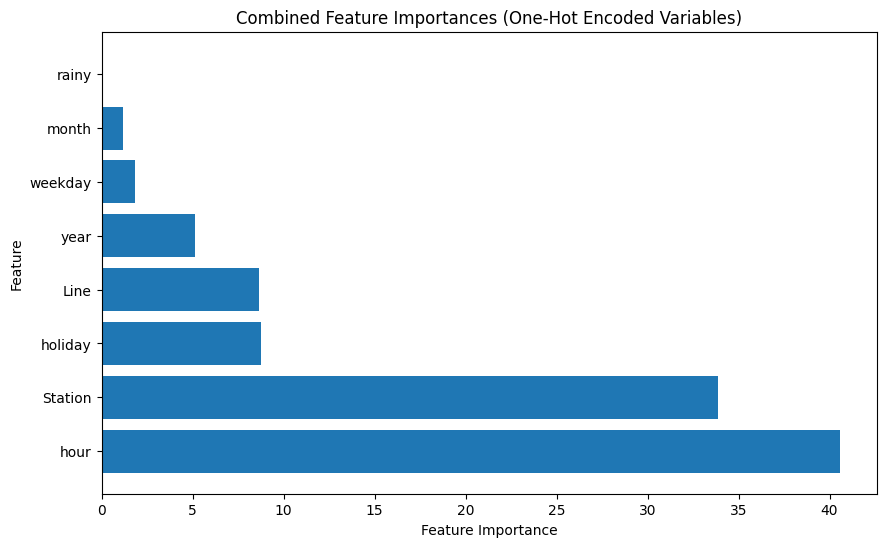

In [10]:
# Train the CatBoostClassifier model
catboost_model = CatBoostRegressor(random_state=42)
catboost_model.fit(X_train, Y_train)

# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Get original feature names (without one-hot encoding)
original_feature_names = [col.split('_')[0] for col in X_train.columns]

# Create a dictionary to store the combined feature importances
combined_feature_importances = {}

# Iterate over the feature importances and sum them for the original feature names
for feature_name, importance in zip(X_train.columns, feature_importances):
    original_feature_name = feature_name.split('_')[0]
    if original_feature_name in combined_feature_importances:
        combined_feature_importances[original_feature_name] += importance
    else:
        combined_feature_importances[original_feature_name] = importance

# Convert the combined feature importances dictionary to a DataFrame
importance_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'], align='center')
plt.yticks(range(len(importance_df)), importance_df.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Combined Feature Importances (One-Hot Encoded Variables)')
plt.show()